In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cmo
import seaborn as sb

Matplotlib is building the font cache; this may take a moment.


In [2]:
def composites_doy(var): 
    if var == 'dic_stf_gas':
        var_folder = 'f_dic'
    elif var == 'o2_stf_gas':
        var_folder = 'f_o2'
    else:
        var_folder = var

    ds = xr.open_dataset(f'/work/Katherine.Turner/tempest-extremes/odiv-251/comp_{var_folder}/comp_{var}_anom.nc', use_cftime=True)
    
    test = ds[f'snap_{var}_anom']
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    masked_var = xr.where(mask, test, np.nan)

    # subsample for periods that we have ocean output (daily, timestamp is 12:00:00)

    ds.snap_time.dt.hour == 12
    time = ds.snap_time[ds.snap_time.dt.hour == 12]
    snap = ds.snapshot[ds.snap_time.dt.hour == 12]

    flux = masked_var[:,:,ds.snap_time.dt.hour == 12]

    # create a dataset to group snapshots by day of year

    ds_masked = ds = xr.Dataset(
        data_vars=dict(
            flux=(["x", "y", "snapshot"], flux.data),
            time=(["snapshot"], time.data),
        ),
        coords=dict(
            x=ds.x.data,
            y=ds.y.data,
            snapshot=snap.data,
        ),
        attrs=dict(description=f"{var} snapshots"),
    )

    flux_avg_tot = flux.mean(dim="snapshot")
    flux_avg_doy = ds_masked.flux.groupby(time.dt.dayofyear).mean(skipna=True)
    
    return flux_avg_tot, flux_avg_doy, time

In [4]:
dic_tot, dic_doy, time2 = composites_doy('dic_stf_gas')
hfds_tot, hfds_doy, time3 = composites_doy('hfds')

In [23]:
r = 10 * 111e3
dx = 0.5 * 111e3
dt = 24 * 60**2

avg_stormdays_yr = time2.groupby(time2.dt.year).count()
avg_storms_day = time2.groupby(time2.dt.dayofyear).count() / 95

# using seasonal cycle of the storm-centered anomalies, create a daily climatology
hfds_ann_cycle_1 = np.pi * r**2 * hfds_doy.mean(dim={"x", "y"}, skipna=True) * avg_storms_day
dic_ann_cycle_1 = np.pi * r**2 * dic_doy.mean(dim={"x", "y"}, skipna=True) * avg_storms_day * 24 * 60**2 * 12.011

In [24]:
storm_heat = hfds_ann_cycle_1.rolling(dayofyear=10, center=True).mean()
storm_carb = dic_ann_cycle_1.rolling(dayofyear=10, center=True).mean()

## Part II - seasonal climatology (clipped via a 10-day running average)

In [8]:
expname = "odiv-251"
path = f'/work/Katherine.Turner/CM4_storms/code/response'

archive_251 = "/archive/Katherine.Turner/xanadu_mom6_20220703/CM4_piControl_C_restartyear148/gfdl.ncrc5-intel22-prod-openmp/pp"

ds_grid = xr.open_dataset(f"{archive_251}/ocean_monthly_1x1deg/ocean_monthly_1x1deg.static.nc")

ocean_area = ds_grid.areacello * ds_grid.wet

SO_area = ocean_area.sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})

In [9]:
def seasonal_avg(v):
    ds = xr.open_dataset(f'{path}/clim_{v}.nc', use_cftime=True)
    SO_total = (ds[f"dailymean_{v}"]*ocean_area).sel(lat=slice(-90,-30)).sum(dim={"lat", "lon"})
    SO_avg = SO_total / SO_area
    seasonal_means = ds[f'dailymean_{v}'].groupby(ds.time.dt.season).mean()
     
    return SO_total, SO_avg, seasonal_means

In [10]:
heat_total, _, heat_seasonal = seasonal_avg("hfds")
carb_total, _, carb_seasonal = seasonal_avg("dic_stf_gas")

In [15]:
clim_heat = heat_total.rolling(time=10, center=True).mean()
clim_carb = carb_total.rolling(time=10, center=True).mean()

## Part III - correlations between climatological and storm-driven heat and carbon uptake

In [26]:
np.corrcoef(clim_heat[10:-10].data, storm_heat[10:-10].data)

array([[ 1.        , -0.58224598],
       [-0.58224598,  1.        ]])

In [27]:
np.corrcoef(clim_carb[10:-10].data, storm_carb[10:-10].data)

array([[1.        , 0.94722085],
       [0.94722085, 1.        ]])

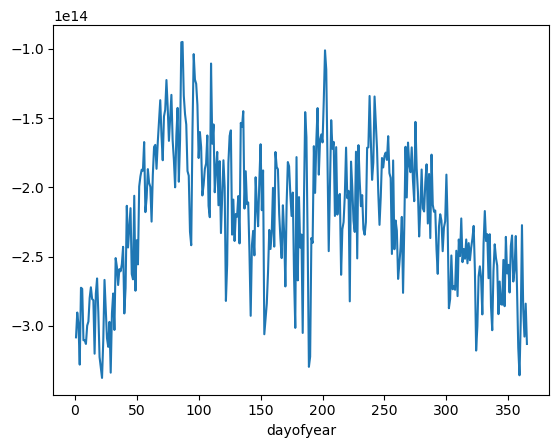

In [25]:
hfds_ann_cycle_1.plot()